In [1]:
import pandas as pd
import itertools
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

/home/yicong/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data=pd.read_csv('data/data2.csv')

In [3]:
data.head(5)

,Unnamed: 0,Review,Rank,Year,class
0,1,Law & Order: Special Victims Unit is one of th...,10,2005,1
1,2,"I started out liking this. But by season 5, it...",1,2016,0
2,3,"This show used to be OK, but over the last cou...",2,2011,0
3,4,"In the dictionary of American TV jargon, this ...",1,2010,0
4,5,"In the past I liked it often, with the New Yor...",1,2015,0


In [8]:
data2007=data.loc[data['Year']==2007]
data2017=data.loc[data['Year']==2017]
print(len(data2007))
print(len(data2017))


2570
3081


In [48]:
x2007=data2007['Review']
y2007=data2007['class']
x2017=data2017['Review']
y2017=data2017['class']
x2007train,x2007test,y2007train,y2007test=train_test_split(x2007,y2007,test_size=0.25)
x2017train,x2017test,y2017train,y2017test=train_test_split(x2017,y2017,test_size=0.25)

In [10]:
tfidf_vectorizer2007=TfidfVectorizer(stop_words='english',ngram_range=(1,2),binary=True)
tfidf_vectorizer2007.fit(x2007train)
tfidf_vectorizer2017=TfidfVectorizer(stop_words='english',ngram_range=(1,2),binary=True)
tfidf_vectorizer2017.fit(x2017train)

TfidfVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [51]:
word2007=tfidf_vectorizer2007.transform(x2007train)
features=tfidf_vectorizer2007.get_feature_names()
word2007test=tfidf_vectorizer2007.transform(x2007test)

In [68]:
word2017=tfidf_vectorizer2017.transform(x2017train)
features2=tfidf_vectorizer2017.get_feature_names()
word2017test=tfidf_vectorizer2017.transform(x2017test)

In [104]:
model1 = RandomForestClassifier()
model1.fit(word2007,y2007train)
model2=RandomForestClassifier()
model2.fit(word2017,y2017train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [72]:
imp=model1.feature_importances_
names=features
imp2=model2.feature_importances_
names2=features2

In [105]:
model1.score(word2007test,y2007test)

0.65474339035769824

In [92]:
model3=BernoulliNB()
model3.fit(word2007,y2007train)
model4=LogisticRegression()
model4.fit(word2007,y2007train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [98]:
fpr1,tpr1,thresholds1 = metrics.roc_curve(y2007test,model1.predict_proba(word2007test)[:,1])
fpr2,tpr2,thresholds2 = metrics.roc_curve(y2007test,model3.predict_proba(word2007test)[:,1])
fpr3,tpr3,thresholds3 = metrics.roc_curve(y2007test,model4.predict_proba(word2007test)[:,1])

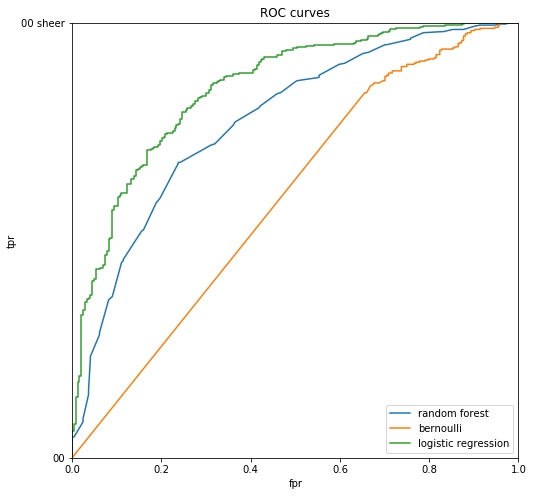

In [99]:
ax=plt.subplot()
plt.plot(fpr1,tpr1,label='random forest')
plt.plot(fpr2,tpr2,label='bernoulli')
plt.plot(fpr3,tpr3,label='logistic regression')

plt.title('ROC curves')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim([0,1])
plt.ylim([0,1])

plt.legend(loc='lower right')
plt.show()

In [9]:
def year_importance(year):
    stryear=str(year)
    data_year=data.loc[data['Year']==year]
    x=data_year['Review']
    y=data_year['class']
    #xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.10)
    tfidf_vectorizer=TfidfVectorizer(stop_words='english',ngram_range=(1,2),binary=True)
    tfidf_vectorizer.fit(x)
    word=tfidf_vectorizer.transform(x)
    names=tfidf_vectorizer.get_feature_names()
    model = RandomForestClassifier()
    model.fit(word,y)
    imp=model.feature_importances_
    topn_ids = np.argsort(imp)[::-1][:100]
    top_feats = [(names[i],imp[i]) for i in topn_ids]
    df=pd.DataFrame(top_feats)
    df.columns = ['feature',stryear]
    return df


In [11]:
for year in range(1999,2018):
    dataframe=year_importance(year)
    stryear=str(year)
    filename=stryear+'.csv'
    dataframe.to_csv(filename)

    